In [1]:
import matplotlib.pyplot as plt
from astropy.table import Table, MaskedColumn
import numpy as np
from matplotlib.pyplot import figure
from astropy.io import fits
import emcee
from tqdm import tqdm_notebook
from scipy import fft
from astropy.nddata import bitmask
from scipy.optimize import least_squares
from chainconsumer import ChainConsumer
from chainconsumer import analysis
import scipy.stats as sp
import numpy.ma as ma
from scipy import special
import os
from matplotlib import rc
from astropy.coordinates import SkyCoord
#import healpy as hp
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=False)

In [2]:
"""
Take time from data
"""
filename = 'SFIELD_43.25--0.5_time_arr,time_scaled,d_obs,uncertainty_mat,match_id_mat.npy'
time_arr,time_scaled,d_obs_,uncertainty_mat,match_id_mat_ = np.load(filename,allow_pickle=True)


#d_obs = ma.masked_values(d_obs,-999.0)
time_arr = ma.masked_values(time_arr,-999.0)
time_scaled = ma.masked_values(time_scaled,-999.0)
uncertainty_mat = ma.masked_values(uncertainty_mat,-999.0)#/5
#match_id_mat = ma.masked_values(match_id_mat,-999.0)

#d_obs = d_obs[:400]
#time_arr = time_arr[:400]
#time_scaled = time_scaled[:400]
#uncertainty_mat = uncertainty_mat[:400]
#match_id_mat = match_id_mat[:400]







In [3]:
##### MICROLENSING FITS #######
def Microlensing_Profile(t,p,t0,t_E):
    def u(t):
        return np.sqrt(p**2 + ((t-t0)/t_E)**2)
    return np.divide(u(t)**2 + 2.,u(t)*np.sqrt(u(t)**2 + 4.))

def residuals(params,d_obs,t,sigma):
    '''
    d_obs for single star: nband x ntime
    t for single star: nband x ntime
    sigma for single star: nband x ntime
    '''
    resid_2d = ( d_obs - ( -2.5*np.log10(Microlensing_Profile(t,params[0],params[1],params[2])) 
                    + np.array([params[3],params[4],params[5],params[6]]).reshape(4,1) ) )/sigma
    resid = np.ndarray.flatten(resid_2d)
    return resid[~resid.mask].data

def chi_sq(params,d_obs,t,sigma):
    '''
    d_obs for single star: nband x ntime
    t for single star: nband x ntime
    sigma for single star: nband x ntime
    '''
    resid_2d=0
    for i in range(len(d_obs)):
        d_obs_inp = d_obs[i] 
        t_inp = t[i]
        sigma_inp = sigma[i]
        resid_2d += np.ma.sum( ( ( (( d_obs_inp - ( -2.5*np.log10(Microlensing_Profile(t_inp,params[0],params[1],params[2])) 
                        + params[i+3])))/sigma_inp)**2 ))
    #resid = np.ma.sum(resid_2d)
    return resid_2d#resid[~resid.mask].data
                    

In [4]:
np.random.seed(32929282)
NStar = 500 #len(time_arr) * 2 #250
time_arr = np.repeat(time_arr,2, axis = 0)
NBand = 4
time = np.zeros((NStar,NBand,time_arr.shape[-1]))
sample_max = time_arr.shape[-1]
baseline = np.random.normal(loc=10,scale=.5,size=(NStar,NBand))

#Create time arrays
for i in range(NStar):
    for j in range(NBand):
        time_draw =  time_arr[i,j,:][~time_arr[i,j,:].mask]#np.sort(np.random.uniform(0,timelength,size=int(np.rint(np.random.uniform(sample_min,sample_max)))))
        time[i,j,:len(time_draw)] = time_draw
        time[i,j,len(time_draw):] = -999.0
        
time = ma.masked_values(time,-999.0)
d_obs = np.zeros((NStar,NBand,sample_max)) - 999.0
d_obs = ma.masked_values(d_obs,-999.0)

#Microlensing parameter distribution
mu_rho, sigma_rho = 2, 0.3
mu_tE, sigma_tE = 1000, 250
f = .5
Num_With_Signal = int(np.rint(f*NStar))
#Sample uncertainty values randomly from the real data uncertainty matrix
real_uncert = np.random.choice(uncertainty_mat[~uncertainty_mat.mask].flatten(),size=NStar*NBand*time_arr.shape[-1])

#mu_A, sigma_A = 0, .5
#mu_B, sigma_B = 0, .5

#General microlensing parameters from the distributions (simple Gaussian)
"""rho = np.random.normal(loc=mu_rho,scale=sigma_rho,size=NStar)
t_rho = np.random.uniform(0,2000,size=NStar)
t_E = np.random.normal(loc=mu_tE,scale=sigma_tE,size=NStar)
"""

t_rho = np.random.uniform(0,2000,size=NStar)
rho = np.random.uniform(0,3,size=NStar)
t_E = np.random.uniform(0,2000,size=NStar)



uncertainty_mat = np.zeros((NStar,NBand,sample_max))
time_scaled = np.zeros((NStar,NBand,sample_max))
count=0
for i in tqdm_notebook(range(NStar)):
    #Scale times so that they all start at t = 0 
    time_scaled[i,:,:] = (time[i,:,:] - time[i,:,:][~time[i,:,:].mask].min())####/time[i,:,:][~time[i,:,:].mask].max()
    time_scaled = ma.masked_values(time_scaled,-999.0)
    
    for j in range(NBand):
        for k in range(np.sum(~time_scaled[i,j,:].mask)):
            if i < Num_With_Signal: #Set flux for curves with signal
                Signal = -2.5*np.log10( Microlensing_Profile(time_scaled[i,j,k],rho[i],t_rho[i],t_E[i]) )
                d_obs[i,j,k] = Signal + np.random.normal(loc=baseline[i,j],scale=real_uncert[count])
                uncertainty_mat[i,j,k] = real_uncert[count]
                count+=1
                
            else: #Set noise curves
                d_obs[i,j,k] = np.random.normal(loc=baseline[i,j],scale=real_uncert[count])
                uncertainty_mat[i,j,k] = real_uncert[count]
                count+=1
                

uncertainty_mat = ma.masked_values(uncertainty_mat,0)
#uncertainty_mat = np.repeat(uncertainty,np.size(d_obs)).reshape(np.shape(d_obs))   

C:\Users\ewist\AppData\Local\Temp/ipykernel_40160/39355844.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(NStar)):


  0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\ewist\anaconda3\envs\microlensing\lib\site-packages\numpy\core\_asarray.py:171: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)
C:\Users\ewist\anaconda3\envs\microlensing\lib\site-packages\numpy\core\_asarray.py:171: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)
C:\Users\ewist\anaconda3\envs\microlensing\lib\site-packages\numpy\core\_asarray.py:171: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)
C:\Users\ewist\anaconda3\envs\microlensing\lib\site-packages\numpy\core\_asarray.py:171: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


Text(0, 0.5, 'Intensity [mag]')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern


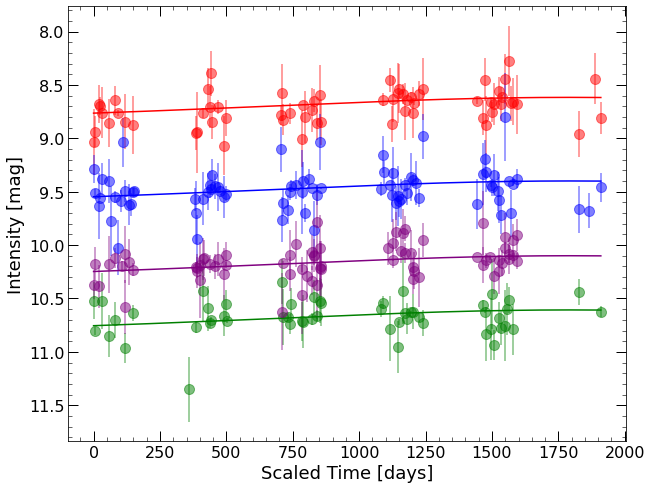

In [5]:
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=False)
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,8)
# matplotlib ticks
ax.tick_params(which='major',labelsize = 16,direction='in', length=10, width=1, colors='k',top=True,right=True) #Major
ax.minorticks_on() #Minor
ax.tick_params(which='minor',direction='in',top=True,right=True, length=4) #Minor
nn = 199

ax.errorbar(x=time_scaled[nn,0,:],y=d_obs[nn,0,:],yerr=uncertainty_mat[nn,0,:],ls='none',marker='.',color='g',ms=20,alpha=.5)
ax.errorbar(x=time_scaled[nn,1,:],y=d_obs[nn,1,:] ,yerr=uncertainty_mat[nn,1,:],ls='none',marker='.',color='r',ms=20,alpha=.5)
ax.errorbar(x=time_scaled[nn,2,:],y=d_obs[nn,2,:],yerr=uncertainty_mat[nn,2,:],ls='none',marker='.',color='blue',ms=20,alpha=.5)
ax.errorbar(x=time_scaled[nn,3,:],y=d_obs[nn,3,:],yerr=uncertainty_mat[nn,3,:],ls='none',marker='.',color='purple',ms=20,alpha=.5)


#ax.scatter(time_test[0,:],gg[0,:,50]+baseline[18,0],color='k')

tt_axis = np.linspace(time_scaled[nn,:,:].min(), time_scaled[nn,:,:].max(),400)
yy = -2.5*np.log10( Microlensing_Profile(tt_axis,rho[nn],t_rho[nn],t_E[nn]+2).reshape(1,-1)) + baseline[nn,:].reshape(4,1)
ax.plot(tt_axis,yy[0,:],color='g')
ax.plot(tt_axis,yy[1,:],color='r')
ax.plot(tt_axis,yy[2,:],color='blue')
ax.plot(tt_axis,yy[3,:],color='purple')

ax.set_ylim(ax.get_ylim()[::-1])




"""
bad_yy = Microlensing_Profile(tt_axis,rho[nn]+0,t_rho[nn],t_E[nn]).reshape(1,-1) + base_temp[nn,:].reshape(4,1)
ax.plot(tt_axis,bad_yy[0,:],color='k',ls='--')
ax.plot(tt_axis,bad_yy[1,:],color='k',ls='--')
ax.plot(tt_axis,bad_yy[2,:],color='k',ls='--')
ax.plot(tt_axis,bad_yy[3,:],color='k',ls='--')
"""

ax.set_xlabel('Scaled Time [days]',fontsize=18)
ax.set_ylabel('Intensity [mag]',fontsize=18)
#ax.set_xlim(750,1500)
#plt.savefig('microlens_sim.pdf')

In [6]:
## NEW
# params are rho_grid, t0_grid, tE_grid: e.g. 50 x 10 x 20 for each
# time is 1d array ntime (will loop through)
def u(t,rho_grid,t0_grid,t_E_grid):
    #Given grids of parameters, calculate seperation u
    #[None,:,:,:]
    return np.sqrt(rho_grid[None,:,:,:]**2 + ( ((t[:,None,None,None]-t0_grid[None,:,:,:])**2)/( t_E_grid[None,:,:,:]**2 ) ) )

def Microlensing_Profile_Production(t,rho_grid,t0_grid,t_E_grid):
    """
    Compute Amplitude 
    
    time is 2d array: nband x ntime
    params are each nsamp
    output is n_rho x n_trho x n_tE x n_time
    """
    u_eval = u(t,rho_grid,t0_grid,t_E_grid)
    return np.divide(u_eval**2 + 2.,u_eval*np.sqrt(u_eval**2 + 4.)) #ntime x rho_axis x trho_axis x tE_axis

def log_like(rho_grid,t0_grid,t_E_grid,baselines,d_obs,t,sigma):
    """
    TESTING FOR AUTOGRAD
    d_obs: [nband] --> ntime. Same for sigma
    baseline: nband
    """
    exp_arg = 0 #np.zeros((rho.shape[0],rho.shape[1],rho.shape[2])) ##rho_axis x trho_axis x tE_axis
    for i in range(len(d_obs)):
        
        #convert amplitude to magnitude 
        S = -2.5*np.log10( Microlensing_Profile_Production(t[i],rho_grid,t0_grid,t_E_grid) ) #ntime x rho_grid x trho_grid x tE_grid
        
        #add to log likelihood
        exp_arg = exp_arg + np.sum( (-1./(2*sigma[i][:,None,None,None]**2))*((d_obs[i][:,None,None,None] - S - baselines[:,:,:,i])**2),axis=0 )  ##rho_axis x trho_axis x tE_axis
        
    return exp_arg  ##rho_axis x trho_axis x tE_axis



def baseline_mag_MLE(rho_grid,t0_grid,t_E_grid,d_obs,t,sigma):
    m_arr = np.zeros((rho_grid.shape[0],rho_grid.shape[1],rho_grid.shape[2],len(d_obs_testing)))
    for i in range(len(d_obs)):
        S = -2.5*np.log10( Microlensing_Profile_Production(t[i],rho_grid,t0_grid,t_E_grid) ) #compute this only once!!!!! Also being called in log_like
        #print(S.shape)
        prefac = np.sum(1./(sigma[i][:,None,None,None]**2),axis=0)
        m_arr[:,:,:,i] =  (1./prefac)*(np.sum( (d_obs[i][:,None,None,None] - S)/(sigma[i][:,None,None,None]**2),axis=0 )) #size of input param grid
    return m_arr
        
    
def u_nsamp1d(t,p,t0,t_E):
    return np.sqrt(p[None,None,:]**2 + ((t[:,:,None]-t0[None,None,:])/t_E[None,None,:])**2)
def Microlensing_Profile_Production_nsamp1d(t,p,t0,t_E):
    """
    time is 2d array: nband x ntime
    params are each nsamp
    """
    u_eval = u_nsamp1d(t,p,t0,t_E)
    return np.divide(u_eval**2 + 2.,u_eval*np.sqrt(u_eval**2 + 4.)) #nband x ntime x nsamp


def log_like_nsamp1d(params,d_obs,t,sigma,baseline):
    """
    d_obs: nband x ntime. Same for sigma
    t: nband x ntime
    params is nparam x nsamp
    baseline: nband
    """
    #rho, t_rho, tE = params[0,:], params[1,:], params[2,:] #each is nsamp
    #m = params[3:,:] #nband x nsamp
    S = -2.5*np.log10( Microlensing_Profile_Production_nsamp1d(t,params[0,:],params[1,:],params[2,:]) ) #nband x ntime x nsamp
    #exp_arg = (-1./(2*sigma[:,:,None]**2))*((d_obs[:,:,None] - S - params[3:,None,:])**2) #nband x ntime x nsamp
    exp_arg = (-1./(2*sigma[:,:,None]**2))*((d_obs[:,:,None] - S - baseline[:,None,:])**2) #nband x ntime x nsamp
    return np.sum(exp_arg,axis=(1,0)) #nsamps

def sign_change(a,axis):
    """
    The philosphy here is that for each cross section (const y,z | const x,z | const x,y) the left out variable
    should have a sign change at a local stationary point.
    Caveat: edge cases. If a[0] is neg and a[1] is pos, these should be tested for MLE.
    We allow this to be the case. Same for if a[-2] is pos and a[-1] is neg, this is flagged as 
    true also. NOTE: if a[0] is pos and a[-1] is neg, both a[0] and a[-1] will be flagged as positive.
    This behavior isn't the best, but it captures all edge cases (plus a little bit extra stuff).
    """
    #True if sign changes at i, i-1, and i+1 in going from i-1 ---> i. i=0 may or may not True, but it's not meaningful.
    #axis is axis of changing input
    asign = np.sign(a)
    roll_right = ((np.roll(asign, 1,axis=axis) - asign) != 0) #everything moves over 1 to right | compare element to right
    roll_left = ((np.roll(asign, -1,axis=axis) - asign) != 0) #everything moves over 1 to left | compare element to left
    sign_change_bool_mat = roll_left | roll_right
    return sign_change_bool_mat 

def BIC(nparams,ndatapoints,max_log_like):
    """
    Lower is better. Lower BIC model wins.
    """
    return nparams*np.log(ndatapoints) - 2.*max_log_like

def MLE_const_flux(d_obs,sigma):
    # d_obs is nband x ntime. Same for sigma
    prefac = np.sum(1./(sigma**2),axis=1) #sum over time
    return (1./prefac)*np.sum(d_obs/(sigma**2),axis=1) #sum over time. Result is nband

def loglike_const_flux(mu,d_obs,sigma):
    # d_obs is nband x ntime. Same for sigma
    #mu is nband
    return np.sum( (-1./(2*sigma**2))*((d_obs-mu.reshape(len(d_obs),1))**2) )

def get_derivatives(RHO,T_RHO,TE,baseline_testing,d_obs_testing,t_testing,sigma_testing):
    rho_deriv = 0 
    t0_deriv = 0
    te_deriv = 0
    for i in range(len(d_obs_testing)):
        u_testing = u(t_testing[i],RHO,T_RHO,TE)
        S = -2.5*np.log10((u_testing**2 + 2)/(u_testing*np.sqrt(u_testing**2 + 4))) #ntime x rho_grid x trho_grid x tE_grid
        prefactor = (-1./(sigma_testing[i][:,None,None,None]**2))*((d_obs_testing[i][:,None,None,None] - S - baseline_testing[:,:,:,i]))
        one_A_dA_du = -8/((u_testing**2 + 2)*(u_testing**2 + 4)*u_testing) * 2.5/np.log(10)

        du_dp = RHO/u_testing
        rho_deriv += np.sum(prefactor * one_A_dA_du * du_dp, axis = 0)
        du_dt0 = -(t_testing[i][:,None,None,None] - T_RHO[None,:,:,:])/(u_testing*TE[None,:,:,:]**2)
        t0_deriv += np.sum(prefactor * one_A_dA_du * du_dt0, axis = 0)
        du_dte = -(t_testing[i][:,None,None,None] - T_RHO[None,:,:,:])**2/(u_testing*TE[None,:,:,:]**3)
        te_deriv += np.sum(prefactor * one_A_dA_du * du_dte, axis = 0)
        
    return rho_deriv, t0_deriv, te_deriv

In [7]:
import time

In [8]:
Delta_BIC = np.zeros(len(d_obs)) - 999.0
Delta_BIC_lst_square = np.zeros(len(d_obs)) - 999.0
MLE_microlensing_params_store = np.zeros((len(d_obs),7)) -999.0
MLE_constflux_params_store = np.zeros((len(d_obs),4)) -999.0
lstsq_fit_sol_arr = np.zeros((len(d_obs),7)) - 999.0

#microlensing_samps_arr = np.zeros((len(d_obs),7,50000)) - 999.0

# create grids of parameters
rho_arr = np.linspace(0.5,3.,7) #10
t_E_arr = np.linspace(80,600,12) #50


for i in tqdm_notebook(range(len(d_obs))):
    
    time0 = time.time()
    source_ind = i
    d_obs_test = d_obs[source_ind,:,:]
    sigma_test = uncertainty_mat[source_ind,:,:]
    time_test = time_scaled[source_ind,:,:]
    baseline_test_truth = baseline[source_ind,:]

    #load in data, put bands together in list
    d1 = d_obs_test[0,:][~d_obs_test[0,:].mask].data
    d2 = d_obs_test[1,:][~d_obs_test[1,:].mask].data
    d3 = d_obs_test[2,:][~d_obs_test[2,:].mask].data
    d4 = d_obs_test[3,:][~d_obs_test[3,:].mask].data
    d_obs_testing = [d1,d2,d3,d4]
    t1 = time_test[0,:][~time_test[0,:].mask].data
    t2 = time_test[1,:][~time_test[1,:].mask].data
    t3 = time_test[2,:][~time_test[2,:].mask].data
    t4 = time_test[3,:][~time_test[3,:].mask].data

    s1 = sigma_test[0][~sigma_test[0,:].mask].data
    s2 = sigma_test[1][~sigma_test[1,:].mask].data
    s3 = sigma_test[2][~sigma_test[2,:].mask].data
    s4 = sigma_test[3][~sigma_test[3,:].mask].data

    sigma_testing = [s1,s2,s3,s4]

    t_testing = [t1,t2,t3,t4]
    
    t_rho_arr = np.linspace(time_test.min(),time_test.max(),24) #80
    RHO, T_RHO, TE = np.meshgrid(rho_arr,t_rho_arr,t_E_arr,indexing='ij',copy=False)
    
    #Analytic MLE for the magnitude baseline (assuming different microlensing params)
    baseline_testing = baseline_mag_MLE(RHO,T_RHO,TE,d_obs_testing,t_testing,sigma_testing)

    #Evaluate gradient across grid
    rho_deriv, t_rho_deriv, t_E_deriv = get_derivatives(RHO,T_RHO,TE,baseline_testing,d_obs_testing,t_testing,sigma_testing)

    time1 = time.time()
    print("Part 1: " + str(time1-time0))

    
    #Find spots where all functions have a stationary point
    rho_sign_bool = sign_change(rho_deriv,0)  
    t_rho_sign_bool = sign_change(t_rho_deriv,1) 
    tE_sign_bool = sign_change(t_E_deriv,2)  
    idx = rho_sign_bool & t_rho_sign_bool & tE_sign_bool #where all true together

    rho_bool_edge_min = (RHO[idx] != rho_arr.min())
    rho_bool_edge_max = (RHO[idx] != rho_arr.max())

    t_rho_bool_edge_min = (T_RHO[idx] != t_rho_arr.min())
    t_rho_bool_edge_max = (T_RHO[idx] != t_rho_arr.max())

    tE_bool_edge_min = (TE[idx] != t_E_arr.min())
    tE_bool_edge_max = (TE[idx] != t_E_arr.max())

    remove_edgevals_bool =np.ones(len(rho_bool_edge_min))# rho_bool_edge_min & rho_bool_edge_max & t_rho_bool_edge_min & t_rho_bool_edge_max & tE_bool_edge_min & tE_bool_edge_max
    remove_edgevals_bool = remove_edgevals_bool.astype(bool)

    rho_vals, t_rho_vals, tE_vals, m0_vals, m1_vals, m2_vals, m3_vals = RHO[idx][remove_edgevals_bool], T_RHO[idx][remove_edgevals_bool], TE[idx][remove_edgevals_bool], baseline_testing[:,:,:,0][idx][remove_edgevals_bool], baseline_testing[:,:,:,1][idx][remove_edgevals_bool], baseline_testing[:,:,:,2][idx][remove_edgevals_bool], baseline_testing[:,:,:,3][idx][remove_edgevals_bool]

    
    if len(rho_vals)!=0:
        #Test the stationary points
        params_stationary = np.vstack([rho_vals,t_rho_vals,tE_vals])
        baseline_trial = np.vstack([m0_vals, m1_vals, m2_vals, m3_vals])
        test_likelihood = log_like_nsamp1d(params_stationary,d_obs_test,time_test,sigma_test,baseline_trial)

        #identify MLE
        samps = params_stationary#[:,np.argmax(test_out)]
        max_log_like_val_microlensing = test_likelihood.max()
        MLE_samp = params_stationary[:,np.argmax(test_likelihood)]
        MLE_baseline = baseline_trial[:,np.argmax(test_likelihood)]

        #Calculate BIC for MLE and constant flux MLE for comparison
        npoints = ma.MaskedArray.count(d_obs_test)
        BIC_val_microlensing = BIC(3,npoints,max_log_like_val_microlensing)
        mu_MLE_constflux = MLE_const_flux(d_obs_test,sigma_test)
        max_log_like_val_constflux = loglike_const_flux(mu_MLE_constflux,d_obs_test,sigma_test)
        BIC_val_constflux = BIC(1.,npoints,max_log_like_val_constflux)

        #Lower BIC is better: the higher the Delta BIC, the more likely it is micolensing
        Delta_BIC[i] = BIC_val_constflux - BIC_val_microlensing
        
        #Store MLE and tested parmeters
        MLE_microlensing_params_store[i,:] = np.array([MLE_samp[0],MLE_samp[1],MLE_samp[2],MLE_baseline[0],MLE_baseline[1],MLE_baseline[2],MLE_baseline[3]])
        MLE_constflux_params_store[i,:] = mu_MLE_constflux
        #microlensing_samps_arr[i,:,:params_stationary.shape[1]] = np.array([params_stationary[0,:],params_stationary[1,:],params_stationary[2,:],baseline_trial[0,:],baseline_trial[1,:],baseline_trial[2,:],baseline_trial[3,:]])

    else: #if no stationary points found, method fails
        Delta_BIC[i] = -999.0
        MLE_microlensing_params_store[i,:] = -999.0
        MLE_constflux_params_store[i,:] = MLE_const_flux(d_obs_test,sigma_test)
    
    #Calculate least-square solution
    npoints = ma.MaskedArray.count(d_obs_test)
    sol = least_squares(fun=residuals,args=(d_obs_test,time_test,sigma_test),
                     x0=np.array([.8,1000,100,20,20,20,20]),bounds=([.3,0.0001,10,0.001,0.001,0.001,0.001],[3,time_scaled[i,:,:].max(),600,100,100,100,100]),
                           method='trf')     
    lstsq_fit_sol_arr[i,:] = sol.x
        
    mu_MLE_constflux = MLE_const_flux(d_obs_test,sigma_test)
    max_log_like_val_constflux = loglike_const_flux(mu_MLE_constflux,d_obs_test,sigma_test)
    BIC_val_constflux = BIC(1.,npoints,max_log_like_val_constflux)
        
    #Calculate BIC and compare to constant flux for least square method
    log_like_lst_square_fit = log_like_nsamp1d(sol.x[:3].reshape(3,1),d_obs_test,time_test,sigma_test,sol.x[3:].reshape(4,1))
    BIC_val_microlensing_lst_square =  BIC(3,npoints,log_like_lst_square_fit)
        
    Delta_BIC_lst_square[i] = BIC_val_constflux - BIC_val_microlensing_lst_square




C:\Users\ewist\AppData\Local\Temp/ipykernel_40160/1803006534.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(d_obs))):


  0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\ewist\AppData\Local\Temp/ipykernel_40160/3249711314.py:45: RuntimeWarning: divide by zero encountered in true_divide
  m_arr[:,:,:,i] =  (1./prefac)*(np.sum( (d_obs[i][:,None,None,None] - S)/(sigma[i][:,None,None,None]**2),axis=0 )) #size of input param grid
C:\Users\ewist\AppData\Local\Temp/ipykernel_40160/3249711314.py:45: RuntimeWarning: invalid value encountered in multiply
  m_arr[:,:,:,i] =  (1./prefac)*(np.sum( (d_obs[i][:,None,None,None] - S)/(sigma[i][:,None,None,None]**2),axis=0 )) #size of input param grid


Part 1: 0.20844554901123047


C:\Users\ewist\AppData\Local\Temp/ipykernel_40160/3249711314.py:57: RuntimeWarning: invalid value encountered in true_divide
  return np.divide(u_eval**2 + 2.,u_eval*np.sqrt(u_eval**2 + 4.)) #nband x ntime x nsamp
C:\Users\ewist\AppData\Local\Temp/ipykernel_40160/1525154559.py:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(p**2 + ((t-t0)/t_E)**2)
C:\Users\ewist\AppData\Local\Temp/ipykernel_40160/1525154559.py:5: RuntimeWarning: invalid value encountered in true_divide
  return np.divide(u(t)**2 + 2.,u(t)*np.sqrt(u(t)**2 + 4.))


Part 1: 0.15317583084106445
Part 1: 0.16756510734558105
Part 1: 0.17080092430114746
Part 1: 0.09476399421691895
Part 1: 0.09444308280944824
Part 1: 0.1941509246826172
Part 1: 0.19131088256835938
Part 1: 0.28679704666137695
Part 1: 0.25215625762939453
Part 1: 0.14779996871948242
Part 1: 0.13840627670288086
Part 1: 0.14108037948608398
Part 1: 0.14483404159545898
Part 1: 0.2914395332336426
Part 1: 0.27263951301574707
Part 1: 0.268237829208374
Part 1: 0.27483248710632324
Part 1: 0.1063239574432373
Part 1: 0.1293032169342041
Part 1: 0.2661747932434082
Part 1: 0.29396605491638184
Part 1: 0.3030099868774414
Part 1: 0.26628804206848145
Part 1: 0.15841078758239746
Part 1: 0.1629478931427002
Part 1: 0.2055513858795166
Part 1: 0.2531266212463379
Part 1: 0.23204255104064941
Part 1: 0.24580979347229004
Part 1: 0.24571609497070312
Part 1: 0.26871824264526367
Part 1: 0.19177865982055664
Part 1: 0.20014500617980957
Part 1: 0.13701772689819336
Part 1: 0.137451171875
Part 1: 0.15829038619995117
Part 1: 

C:\Users\ewist\anaconda3\envs\microlensing\lib\site-packages\numpy\core\_asarray.py:171: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)
C:\Users\ewist\anaconda3\envs\microlensing\lib\site-packages\numpy\core\_asarray.py:171: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)
C:\Users\ewist\anaconda3\envs\microlensing\lib\site-packages\numpy\core\_asarray.py:171: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)
C:\Users\ewist\anaconda3\envs\microlensing\lib\site-packages\numpy\core\_asarray.py:171: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


NameError: name 'microlensing_samps_arr' is not defined

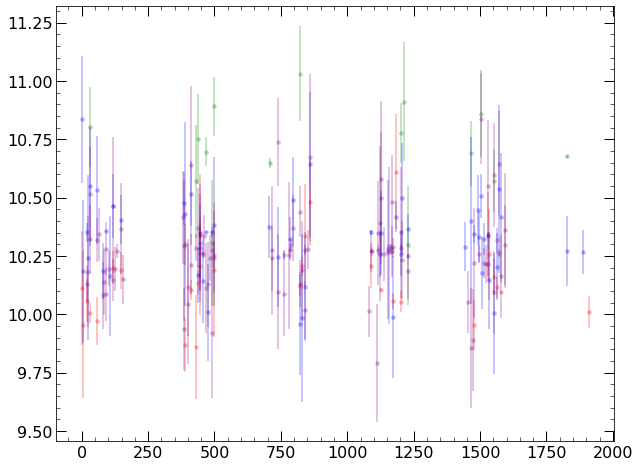

In [9]:
from matplotlib.patches import Patch
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=False)

nn = 19

fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,8)
# matplotlib ticks
ax.tick_params(which='major',labelsize = 16,direction='in', length=10, width=1, colors='k',top=True,right=True) #Major
ax.minorticks_on() #Minor
ax.tick_params(which='minor',direction='in',top=True,right=True, length=4) #Minor
alph_pts = .3
ms = 9
ax.errorbar(x=time_scaled[nn,0,:],y=d_obs[nn,0,:],yerr=uncertainty_mat[nn,0,:],ls='none',marker='.',color='g',ms=ms,alpha=alph_pts,markeredgecolor='none')
ax.errorbar(x=time_scaled[nn,1,:],y=d_obs[nn,1,:] ,yerr=uncertainty_mat[nn,1,:],ls='none',marker='.',color='r',ms=ms,alpha=alph_pts,markeredgecolor='none')
ax.errorbar(x=time_scaled[nn,2,:],y=d_obs[nn,2,:],yerr=uncertainty_mat[nn,2,:],ls='none',marker='.',color='blue',ms=ms,alpha=alph_pts,markeredgecolor='none')
ax.errorbar(x=time_scaled[nn,3,:],y=d_obs[nn,3,:],yerr=uncertainty_mat[nn,3,:],ls='none',marker='.',color='purple',ms=ms,alpha=alph_pts,markeredgecolor='none')


#ax.scatter(time_test[0,:],gg[0,:,50]+baseline[18,0],color='k')



tt_axis = np.linspace(time_scaled[nn,:,:].min(),time_scaled[nn,:,:].max(),1000)



alph = .4
lw=.5
samp_count = np.argmax(microlensing_samps_arr[nn,0,:]==-999.0)
color='gray'
for i in tqdm_notebook(range(samp_count)):
#for i in tqdm_notebook(range(100)):
    draw_yy = -2.5*np.log10( Microlensing_Profile(tt_axis,microlensing_samps_arr[nn,0,i],microlensing_samps_arr[nn,1,i],microlensing_samps_arr[nn,2,i]).reshape(1,-1) ) + microlensing_samps_arr[nn,3:,i].reshape(4,1)
    ax.plot(tt_axis,draw_yy[0,:],color=color,alpha=alph,lw=lw)
    ax.plot(tt_axis,draw_yy[1,:],color=color,alpha=alph,lw=lw)
    ax.plot(tt_axis,draw_yy[2,:],color=color,alpha=alph,lw=lw)
    ax.plot(tt_axis,draw_yy[3,:],color=color,alpha=alph,lw=lw)





## TRUTH:
yy = -2.5*np.log10( Microlensing_Profile(tt_axis,rho[nn],t_rho[nn],t_E[nn]).reshape(1,-1) ) + baseline[nn,:].reshape(4,1)
ax.plot(tt_axis,yy[0,:],color='g',ls='-')
ax.plot(tt_axis,yy[1,:],color='r',ls='-')
ax.plot(tt_axis,yy[2,:],color='blue',ls='-')
ax.plot(tt_axis,yy[3,:],color='purple',ls='-')


## MLE
MLE_yy = -2.5*np.log10( Microlensing_Profile(tt_axis,MLE_microlensing_params_store[nn,0],MLE_microlensing_params_store[nn,1],MLE_microlensing_params_store[nn,2]).reshape(1,-1) ) + MLE_microlensing_params_store[nn,3:].reshape(4,1)
ax.plot(tt_axis,MLE_yy[0,:],color='deepskyblue',alpha=.8,lw=1.5,zorder=3)
ax.plot(tt_axis,MLE_yy[1,:],color='deepskyblue',alpha=.8,lw=1.5,zorder=3)
ax.plot(tt_axis,MLE_yy[2,:],color='deepskyblue',alpha=.8,lw=1.5,zorder=3)
ax.plot(tt_axis,MLE_yy[3,:],color='deepskyblue',alpha=.8,lw=1.5,zorder=3)

## SCIPY
yy_scipy = -2.5*np.log10( Microlensing_Profile(tt_axis,lstsq_fit_sol_arr[nn,0],lstsq_fit_sol_arr[nn,1],lstsq_fit_sol_arr[nn,2]).reshape(1,-1) ) + lstsq_fit_sol_arr[nn,3:].reshape(4,1)
ax.plot(tt_axis,yy_scipy[0,:],color='g',ls='--')
ax.plot(tt_axis,yy_scipy[1,:],color='r',ls='--')
ax.plot(tt_axis,yy_scipy[2,:],color='blue',ls='--')
ax.plot(tt_axis,yy_scipy[3,:],color='purple',ls='--')


#ax.hlines(mu_MLE_constflux[0],0,2000,color='k',lw=5)
#ax.hlines(mu_MLE_constflux[1],0,2000,color='k',lw=5)
#ax.hlines(mu_MLE_constflux[2],0,2000,color='k',lw=5)
#ax.hlines(mu_MLE_constflux[3],0,2000,color='k',lw=5)







from matplotlib.lines import Line2D
custom_lines = [
                Line2D([0], [0], color='gray', lw=1,ls='-'),
               Line2D([0], [0], color='deepskyblue',alpha=.8, lw=1,ls='-')]


pa1 = Patch(facecolor='g', edgecolor='black',lw=0)
pa2 = Patch(facecolor='r', edgecolor='black',lw=0)
pa3 = Patch(facecolor='blue', edgecolor='black',lw=0)
pa4 = Patch(facecolor='purple', edgecolor='black',lw=0)

pb1 = Patch(facecolor='g', edgecolor='black',ls='--',lw=1.5)
pb2 = Patch(facecolor='r', edgecolor='black',ls='--',lw=1.5)
pb3 = Patch(facecolor='blue', edgecolor='black',ls='--',lw=1.5)
pb4 = Patch(facecolor='purple', edgecolor='black',ls='--',lw=1.5)

plt.plot(np.zeros(1), np.zeros([1,3]), color='w', alpha=0, label=' ')

leg1 = ax.legend(handles=[pa1, pb1, pa2, pb2, pa3, pb3,pa4,pb4],
          labels=['', '', '', '','','', 'Truth', 'Least Squares Optimizer'],
          ncol=4, handletextpad=0.4, handlelength=.5, columnspacing=-0.5,labelspacing=.5,
          loc='upper left', fontsize=20,frameon=False)

leg2 = ax.legend(custom_lines, [r'$\partial\ell / \partial \theta = 0$',r'$\sim \mathrm{MLE}$'],fontsize=20,frameon=False,loc='upper right')

ax.set_ylim(d_obs[nn].min()-.95,d_obs[nn].max()+.5)

ax.set_ylim(ax.get_ylim()[::-1])




ax.add_artist(leg1)

ax.set_xlabel('Scaled Time [days]',fontsize=18)
ax.set_ylabel('Intensity [mag]',fontsize=18)
#
#plt.savefig('SimTestResult_MLE_Derivs_illustration_samp5.pdf')#2

In [10]:
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

In [11]:
y_true = np.append(np.ones(Num_With_Signal), np.zeros(NStar - Num_With_Signal))

thresholds = np.arange(0,10, 0.01)
true_negatives = np.zeros(len(thresholds))
false_positives = np.zeros(len(thresholds))
false_negatives = np.zeros(len(thresholds))
true_positives = np.zeros(len(thresholds))
for i, threshold in tqdm(enumerate(thresholds)):
    y_predict = (Delta_BIC > threshold)
    tn, fp, fn, tp = confusion_matrix(y_true, y_predict).ravel()
    true_negatives[i] = tn
    false_positives[i] = fp
    false_negatives[i] = fn
    true_positives[i] = tp

1000it [00:03, 329.78it/s]


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern


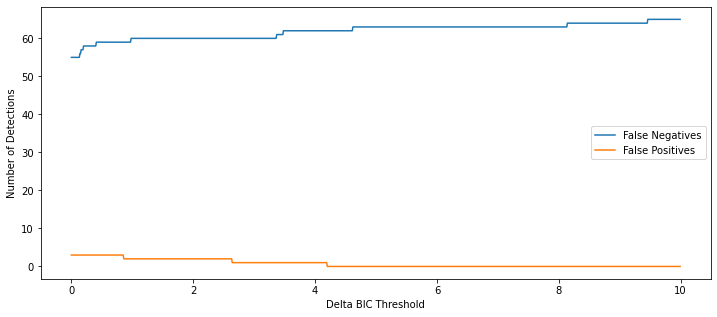

In [12]:
fig, ax = plt.subplots(figsize= (12,5))
ax.plot(thresholds, false_negatives, label = 'False Negatives')
ax.plot(thresholds, false_positives, label = 'False Positives')
ax.set_xlabel('Delta BIC Threshold')
ax.set_ylabel('Number of Detections')
plt.legend()

In [15]:
rho_detected = []
te_detected = []
rho_non_detected = []
te_non_detected = []
for i, star in tqdm(enumerate(range(Num_With_Signal))):
    if (Delta_BIC[i] > 5):
        rho_detected.append(rho[i])
        te_detected.append(t_E[i])
    else:
        rho_non_detected.append(rho[i])
        te_non_detected.append(t_E[i])
        
rho_detected = np.array(rho_detected)
te_detected = np.array(te_detected)
rho_non_detected = np.array(rho_non_detected)
te_non_detected = np.array(te_non_detected)

250it [00:00, 250735.53it/s]


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern


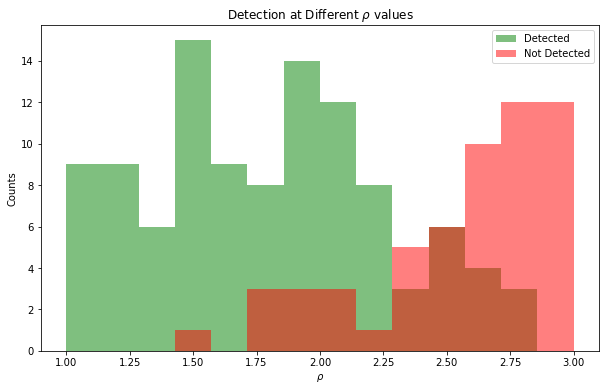

In [16]:
rho_bins = np.linspace(1,3,15)

fig, ax = plt.subplots(figsize = (10,6))
ax.hist(rho_detected, bins = rho_bins, label = 'Detected', alpha = 0.5, color = 'g');
ax.hist(rho_non_detected, bins = rho_bins, label = 'Not Detected', alpha = 0.5, color = 'r');
ax.set_xlabel(r'$\rho$')
ax.set_ylabel('Counts')
ax.set_title(r'Detection at Different $\rho$ values')
plt.legend()
plt.savefig('Plots/rho_hist.png')

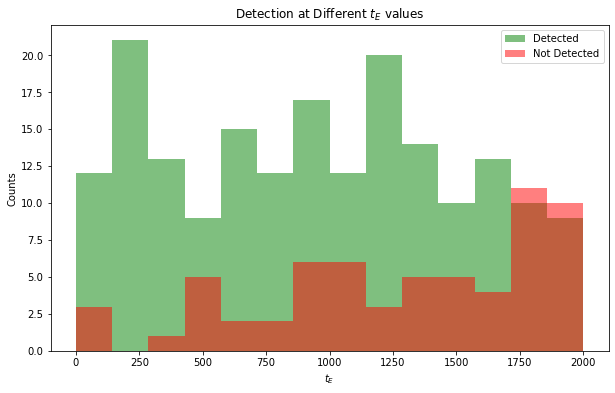

In [17]:
te_bins = np.linspace(0,2000,15)

fig, ax = plt.subplots(figsize = (10,6))
ax.hist(te_detected, bins = te_bins, label = 'Detected', alpha = 0.5, color = 'g');
ax.hist(te_non_detected, bins = te_bins, label = 'Not Detected', alpha = 0.5, color = 'r');
ax.set_xlabel(r'$t_{E}$')
ax.set_ylabel('Counts')
ax.set_title(r'Detection at Different $t_{E}$ values')
plt.legend()
plt.savefig('Plots/t_e_hist.png')

In [19]:
hist_detect, rho_edges, te_edges = np.histogram2d(rho_detected, te_detected, bins = [rho_bins, te_bins])

In [20]:
hist_non_detect, _, _ = np.histogram2d(rho_non_detected, te_non_detected, bins = [rho_bins, te_bins])

C:\Users\ewist\AppData\Local\Temp/ipykernel_40160/2986157978.py:2: RuntimeWarning: invalid value encountered in true_divide
  im = ax.imshow(hist_detect/(hist_detect+hist_non_detect),


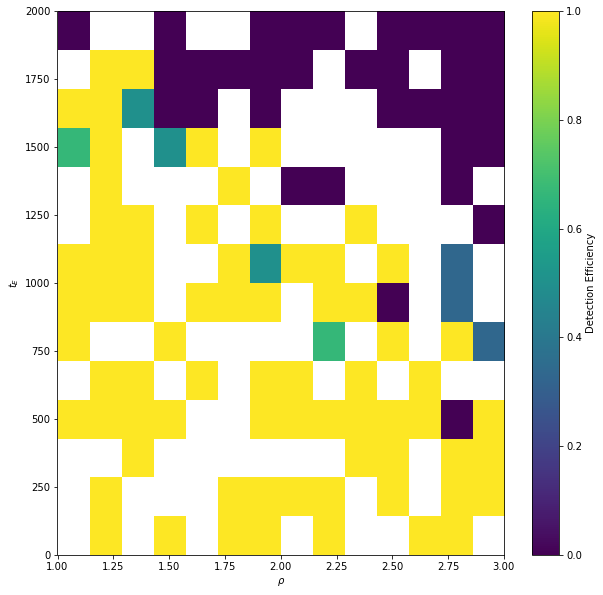

In [21]:
fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(hist_detect/(hist_detect+hist_non_detect),
               extent = [rho_bins[0],rho_bins[-1],te_bins[0],te_bins[-1]], origin ='lower')
ax.set_aspect('auto')
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$t_{E}$')
cb = fig.colorbar(im)
cb.set_label('Detection Efficiency')
#plt.savefig('Plots/Detection_Efficiency.png')

In [22]:
rho_lst_detected = []
te_lst_detected = []
rho_lst_non_detected = []
te_lst_non_detected = []
for i, star in tqdm(enumerate(range(Num_With_Signal))):
    if (Delta_BIC_lst_square[i] > 5):
        rho_lst_detected.append(rho[i])
        te_lst_detected.append(t_E[i])
    else:
        rho_lst_non_detected.append(rho[i])
        te_lst_non_detected.append(t_E[i])
        
rho_lst_detected = np.array(rho_lst_detected)
te_lst_detected = np.array(te_lst_detected)
rho_lst_non_detected = np.array(rho_lst_non_detected)
te_lst_non_detected = np.array(te_lst_non_detected)

250it [00:00, 260128.01it/s]


In [23]:
hist_lst_detect, rho_edges, te_edges = np.histogram2d(rho_lst_detected, te_lst_detected, bins = [rho_bins, te_bins])
hist_lst_non_detect, _, _ = np.histogram2d(rho_lst_non_detected, te_lst_non_detected, bins = [rho_bins, te_bins])

C:\Users\ewist\AppData\Local\Temp/ipykernel_40160/2911018083.py:2: RuntimeWarning: invalid value encountered in true_divide
  im = ax.imshow(hist_lst_detect/(hist_lst_detect+hist_lst_non_detect),


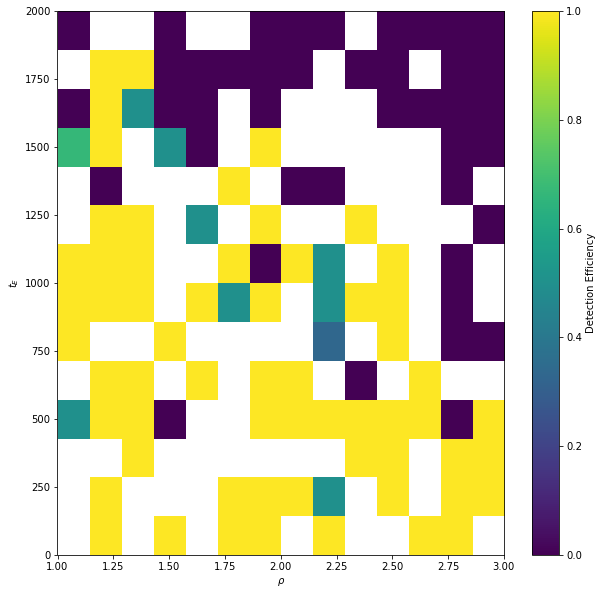

In [24]:
fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(hist_lst_detect/(hist_lst_detect+hist_lst_non_detect),
               extent = [rho_bins[0],rho_bins[-1],te_bins[0],te_bins[-1]], origin ='lower')
ax.set_aspect('auto')
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$t_{E}$')
cb = fig.colorbar(im)
cb.set_label('Detection Efficiency')
#plt.savefig('Plots/Detection_Efficiency.png')